## For prototyping magic plots



In [1]:

'''This cell imports the necessary libraries and modules for the analysis.'''
import sys, os
from pathlib import Path

# Robustly ensure 'src' is on sys.path (works whether CWD is repo root or notebooks/)
for p in [Path.cwd(), *Path.cwd().parents]:
    cand = p / "src"
    if cand.exists():
        sys.path.insert(0, str(cand))
        break

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Importing modules
from qft.udw_qutrits import detector_state      
from magic.wigner_polytope import wigner_inequalities
from utils.state_checks import is_valid_state, validate_and_print


plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{lmodern}",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# def partial_trace_second_qutrit(rho):
#     """Trace out the second qutrit from a 2-qutrit density matrix (9x9) to get a 3x3 reduced state.
#     Assumes Hilbert space ordering H = H_A ⊗ H_B with dims (3,3).
#     """
#     rho = np.asarray(rho)
#     rho = rho.reshape(3,3,3,3)  # (i_A, i_B, j_A, j_B)
#     # Trace over B (second qutrit): sum over i_B == j_B
#     red = np.einsum('ibja->ij', rho)
#     return red



def reduce_state(rho: np.ndarray) -> np.ndarray:
    """
    Partial trace over the second qutrit (B) of a 2-qutrit density matrix.

    Parameters
    ----------
    rho : np.ndarray
        9x9 density matrix for a 2-qutrit system (A⊗B), dtype complex recommended.

    Returns
    -------
    np.ndarray
        3x3 reduced density matrix for the first qutrit (A).
    """
    rho = np.asarray(rho)
    if rho.shape != (9, 9):
        raise ValueError("rho must be a 9x9 matrix for a 2-qutrit system.")

    # Reshape to indices [i_A, i_B, j_A, j_B]
    rho_reshaped = rho.reshape(3, 3, 3, 3)

    # Trace over B: sum over i_B == j_B
    rho_A = np.trace(rho_reshaped, axis1=1, axis2=3)  # shape (3,3)

    return rho_A


## Wigner negativity vs gap ($\Omega$)

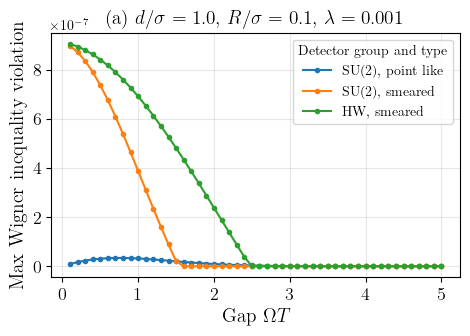

In [2]:

'''This cell generates the plots for Wigner negativity vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 1.0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

group_types = [("SU2", "point_like"), ("SU2", "smeared"), ("HW", "smeared")]
labels = {
    ("SU2", "point_like"): "SU(2), point like",
    ("SU2", "smeared"): "SU(2), smeared",
    ("HW", "smeared"): "HW, smeared"
}

plt.figure(figsize=(4.8,3.6))

# Sweep gaps
gaps = np.linspace(0.1, 5, 50)  # avoid zero to keep numerics well-behaved


for group, detector_type in group_types:
    wn_vals = []  # max violation per gap
    violated_points_list = []  # list of violating (i,j) points per gap
    for gap in gaps:
        rho = detector_state(
            gap=gap,
            switching=switching,
            separation=separation,
            regulator=regulator,
            smearing=smearing,
            regularization=regularization,
            detector_type=detector_type,
            group=group,
            lam=lam,
        )
        if is_valid_state(rho):
            rho_1 = reduce_state(rho)  # reduce to first qutrit
            max_violation, violating_points = wigner_inequalities(rho_1)
            wn_vals.append(max_violation)
            violated_points_list.append(violating_points)
            # if max_violation > 0:
            #     print(f"[{group}, {detector_type}] gap={gap:.3g}: violated points = {violating_points}")
        else:
            print("Invalid state detected at gap =", gap)
            validate_and_print(rho)
            break

    wn_vals = np.array(wn_vals)
    plt.plot(gaps[:len(wn_vals)], wn_vals, marker=".", lw=1.5, label=labels[(group, detector_type)])


plt.xlabel(r"{Gap} $\Omega T$",fontsize=14)
plt.ylabel(r"{Max Wigner inequality violation}",fontsize=14)
plt.title(rf"(a) $d/\sigma={separation}$, $R/\sigma={smearing}$, $\lambda={lam}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(title="Detector group and type")
plt.tight_layout()
# plt.savefig("wigner_negativity_vs_gap_different_models.pdf")
plt.show()

